In [5]:
#| default_exp experimental.gaussian

# Simple Gaussian

> Implement a very simple gaussian without rotations of domain.

We're finding some struggle when working with full complex gaussians and gabors, specially in the domain rotation, so we're going to try very simple gaussians that don't use matrix inversions:

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
#| export
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from einops import rearrange, repeat, reduce

In [8]:
#| hide
import os; os.environ["CUDA_VISIBLE_DEVICES"]="3"
import matplotlib.pyplot as plt

## Base formula

Following [Wikipedia](https://en.wikipedia.org/wiki/Gaussian_function#Two-dimensional_Gaussian_function), a two dimensional elliptical Gaussian is expressed as:

$$
f(x,y) = A e^{-(a(x-x_0)^2 + 2b(x-x_0)(y-y_0) + c(y-y_0)^2)}
$$

where the matrix 
\begin{bmatrix}
a & b \\
b & c
\end{bmatrix}

must be positive-definite, meaning that $ac - b^2 > 0$.

**Parameters**:
- $A$: height of the peak.
- $x_0$ and $y_0$ represent the center of the gaussian.
- $a = \frac{cos^2\theta}{2\sigma_x^2}$ + \frac{cos^2\theta}{2\sigma_x^2}$

We can, as well, use this other formulation:

$$
f(x,y) = Ae^{-(\frac{(x-x_0)^2}{2\sigma_x^2} + \frac{(y-y_0)^2}{2\sigma_y^2})}
$$

In [9]:
def simple_gaussian(x, y, x0, y0, sigma_x, sigma_y, A=1):
    return A*np.exp(-((x-x0)**2/(2*sigma_x**2)+(y-y0)**2/(2*sigma_y**2)))

In [10]:
x0, y0 = 5, 5
x, y = np.meshgrid(range(11), range(11))

x.shape, y.shape

((11, 11), (11, 11))

In [11]:
g = simple_gaussian(x, y, 5, 5, 2, 2)
g.shape

(11, 11)

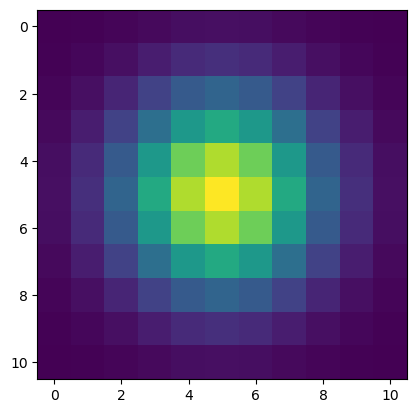

In [12]:
plt.imshow(g)
plt.show()

If we want to put this into a layer:

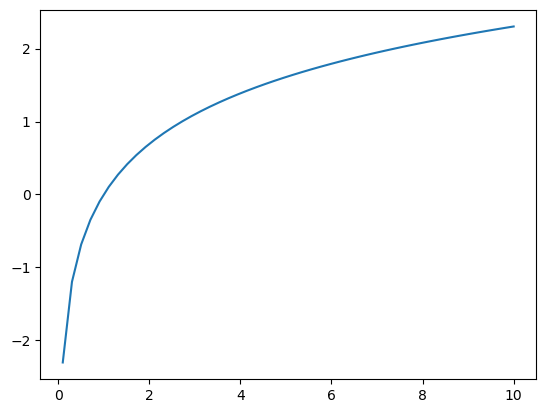

In [13]:
plt.plot(np.linspace(0.1,10), np.log(np.linspace(0.1,10)))
plt.show()

In [14]:
#| export
class SimpleGaussian(layers.Layer):
    """Simple gaussian layer."""
    
    def __init__(self,
                 filters,
                 kernel_size,
                 A=1, # Height of the peak of the Gaussian.
                 strides=1, # Strides of the convolution.
                 padding="SAME", # Can be "SAME" or "VALID".
                 normalize=True, # Wether to normalize the output filters or not.
                 **kwargs,
                 ):
        super(SimpleGaussian, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.A = tf.cast(A, dtype=tf.float32)
        self.strides = strides
        self.padding = padding
        self.normalize = normalize

    def build(self,
              input_shape,
              ):
        self.x0 = tf.Variable([self.kernel_size//2]*self.filters, trainable=True, name="x0", dtype=tf.float32)
        self.y0 = tf.Variable([self.kernel_size//2]*self.filters, trainable=True, name="y0", dtype=tf.float32)
        self.logsigma_x = tf.Variable(np.random.uniform(low=-2, high=2, size=self.filters), trainable=True, name="logsigma_x", dtype=tf.float32)
        self.logsigma_y = tf.Variable(np.random.uniform(low=-2, high=2, size=self.filters), trainable=True, name="logsigma_y", dtype=tf.float32)

    @property
    def sigma_x(self):
        return tf.math.exp(self.logsigma_x)

    @property
    def sigma_y(self):
        return tf.math.exp(self.logsigma_y)

    def call(self,
             X,
             training=False,
             ):
        
        ## 1. Build the filters (n_filters, kernel_size, kernel_size)
        filters = self.build_filters()

        ## 2. Reshape so they match what Keras expects (Kx, Ky, Cin, Cout)
        filters = repeat(filters, "n_filters kx ky -> kx ky Cin n_filters", Cin=X.shape[-1])

        return tf.nn.conv2d(X, filters, strides=self.strides, padding=self.padding)
    
    @tf.function
    def _build_filter(self,
                      x, # X domain.
                      y, # Y domain.
                      x0, # Mean of X.
                      y0, # Mean of Y.
                      sigma_x, # Width of X.
                      sigma_y, # Width of Y.
                      A, # Height of the peak.
                      ):
        """Builds the gaussian filters using the parameters of the layer."""

        ## 2. Build the gaussian
        if self.normalize: A = 1/(2*3.14*sigma_x*sigma_y)
        return A*tf.math.exp(-((x-x0)**2/(2*sigma_x**2)+(y-y0)**2/(2*sigma_y**2)))

    @tf.function
    def build_filters(self):
        ## 1. Build domain
        x, y = tf.meshgrid(tf.range(self.kernel_size), tf.range(self.kernel_size))
        x, y = tf.cast(x, dtype=tf.float32), tf.cast(y, dtype=tf.float32)
        
        ## 2. Initialize empty `TensorArray`
        filters = tf.TensorArray(dtype = tf.float32, size = self.filters)

        for n in tf.range(start=0, limit=self.filters, dtype=tf.int32):
            filters = filters.write(n, 
                                    self._build_filter(x, y, 
                                                       tf.gather(self.x0, n), tf.gather(self.y0, n), 
                                                       tf.gather(self.sigma_x, n), tf.gather(self.sigma_y, n),
                                                       self.A))

        filters = filters.stack()
        # Normalize the filters
        # if self.normalize: 
        #     max_per_filter = reduce(filters, "filters Ncols Nrows -> filters () ()", "max")
        #     min_per_filter = reduce(filters, "filters Ncols Nrows -> filters () ()", "min")
        #     filters = (filters-min_per_filter)/(max_per_filter-min_per_filter)
        return filters

    def show_filters(self,
                     show=True, # Wether to do plt.show() or not.
                     ):
        """Plots the filters created with the current parameters."""
        ncols = int(np.sqrt(self.filters))
        nrows = int(self.filters-ncols)
        if nrows == 0: nrows == 1
        filters = self.build_filters().numpy()
        fig, axes = plt.subplots(ncols, nrows)
        for filter, ax in zip(filters, axes.ravel()):
            ax.imshow(filter)
            ax.axis("off")
        if show: plt.show()
        

In [15]:
gl = SimpleGaussian(filters=4, kernel_size=11)
gl.build(())

2022-10-09 20:07:45.328185: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5435 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN Black, pci bus id: 0000:84:00.0, compute capability: 3.5


2022-10-09 20:07:46.028716: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


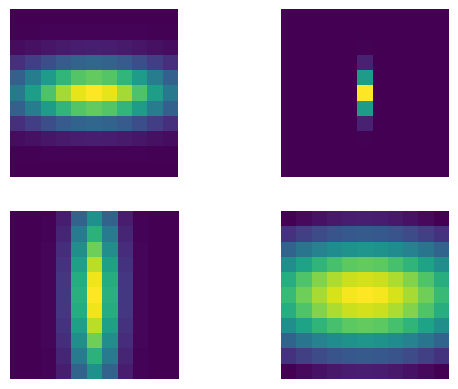

In [16]:
gl.show_filters()

## Simple model

In [17]:
from tensorflow.keras.datasets import cifar10

In [18]:
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

X_train = X_train/255.0
X_test = X_test/255.0

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [19]:
model = tf.keras.Sequential([
    SimpleGaussian(filters=4, kernel_size=11, input_shape=X_train[0].shape),
    layers.MaxPool2D(2),
    layers.GlobalAveragePooling2D(),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_gaussian_1 (SimpleGau (None, 32, 32, 4)         16        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 4)         0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 4)                 0         
_________________________________________________________________
dense (Dense)                (None, 10)                50        
Total params: 66
Trainable params: 66
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = model.fit(X_train, Y_train, epochs=5, batch_size=128, validation_split=0.2)

Epoch 1/5


2022-10-09 20:07:55.155221: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100
2022-10-09 20:07:55.618908: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


313/313 [==============================] - 9s 19ms/step - loss: 2.4712 - accuracy: 0.0926 - val_loss: 2.3077 - val_accuracy: 0.1027
Epoch 2/5
313/313 [==============================] - 5s 17ms/step - loss: 2.3007 - accuracy: 0.0983 - val_loss: 2.2971 - val_accuracy: 0.1057
Epoch 3/5
313/313 [==============================] - 5s 17ms/step - loss: 2.2957 - accuracy: 0.1097 - val_loss: 2.2928 - val_accuracy: 0.1087
Epoch 4/5
313/313 [==============================] - 5s 17ms/step - loss: 2.2918 - accuracy: 0.1157 - val_loss: 2.2889 - val_accuracy: 0.1155
Epoch 5/5
313/313 [==============================] - 5s 17ms/step - loss: 2.2884 - accuracy: 0.1175 - val_loss: 2.2854 - val_accuracy: 0.1249


In [21]:
model.layers[0].trainable_variables

[<tf.Variable 'simple_gaussian_1/x0:0' shape=(4,) dtype=float32, numpy=array([4.924662 , 4.7507434, 5.2441254, 4.725989 ], dtype=float32)>,
 <tf.Variable 'simple_gaussian_1/y0:0' shape=(4,) dtype=float32, numpy=array([3.9362297, 5.3472905, 4.764661 , 5.4276137], dtype=float32)>,
 <tf.Variable 'simple_gaussian_1/logsigma_x:0' shape=(4,) dtype=float32, numpy=array([ 1.4867465, -1.5360956,  1.9485881, -1.6307621], dtype=float32)>,
 <tf.Variable 'simple_gaussian_1/logsigma_y:0' shape=(4,) dtype=float32, numpy=array([-0.6090842,  1.7246387,  1.6410862,  0.899996 ], dtype=float32)>]

## Putting it into a GDN

> Now that we saw that we can optimize the gaussian's parameters, let's put it into a GDN.

In [59]:
class GDNConv(layers.Layer):
    """GDN that takes as input a specific layer to use."""

    def __init__(self,
                 layer, # Layer to be used to extract the normalization.
                 **kwargs,
                 ):
        super(GDNConv, self).__init__(**kwargs)
        self.layer = layer

    def build(self,
              input_shape,
              ):
        self.layer.build(input_shape)
        self.alpha = tf.Variable(2, trainable=False, name="alpha", dtype=tf.float32)
        self.epsilon = tf.Variable(1/2, trainable=False, name="epsilon", dtype=tf.float32)
        # self.beta = tf.Variable(1, trainable=True, name="beta", dtype=tf.float32)

    def call(self,
             X,
             training=False,
             ):
        norm = tf.math.pow(X, self.alpha)
        norm = self.layer(norm, training=training)#+self.beta
        norm = tf.math.pow(norm, self.epsilon)
        # norm = tf.clip_by_value(norm, clip_value_min=1e-5, clip_value_max=tf.reduce_max(norm))
        return X / norm

In [56]:
model = tf.keras.Sequential([
    GDNConv(SimpleGaussian(filters=3, kernel_size=11), input_shape=X_train[0].shape),
    layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
    layers.MaxPool2D(2),
    layers.GlobalAveragePooling2D(),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gdn_conv_4 (GDNConv)         (None, 32, 32, 3)         14        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
global_average_pooling2d_5 ( (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                330       
Total params: 1,240
Trainable params: 1,238
Non-trainable params: 2
_________________________________________________________________


In [24]:
model.layers[0].trainable=False
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gdn_conv (GDNConv)           (None, 32, 32, 3)         14        
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 1,240
Trainable params: 1,226
Non-trainable params: 14
_________________________________________________________________


In [57]:
history = model.fit(X_train, Y_train, epochs=1, batch_size=128, validation_split=0.2)

313/313 [==============================] - 8s 19ms/step - loss: 2.3027 - accuracy: 0.1001 - val_loss: 2.3027 - val_accuracy: 0.0952


In [58]:
model.layers[0].variables

[<tf.Variable 'gdn_conv_4/simple_gaussian_6/x0:0' shape=(3,) dtype=float32, numpy=array([nan, nan, nan], dtype=float32)>,
 <tf.Variable 'gdn_conv_4/simple_gaussian_6/y0:0' shape=(3,) dtype=float32, numpy=array([nan, nan, nan], dtype=float32)>,
 <tf.Variable 'gdn_conv_4/simple_gaussian_6/logsigma_x:0' shape=(3,) dtype=float32, numpy=array([nan, nan, nan], dtype=float32)>,
 <tf.Variable 'gdn_conv_4/simple_gaussian_6/logsigma_y:0' shape=(3,) dtype=float32, numpy=array([nan, nan, nan], dtype=float32)>,
 <tf.Variable 'gdn_conv_4/alpha:0' shape=() dtype=float32, numpy=2.0>,
 <tf.Variable 'gdn_conv_4/epsilon:0' shape=() dtype=float32, numpy=0.5>]

## Step by step

> Let's see if we can find anything...

In [60]:
model = tf.keras.Sequential([
    GDNConv(SimpleGaussian(filters=3, kernel_size=11), input_shape=X_train[0].shape),
    layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
    layers.MaxPool2D(2),
    layers.GlobalAveragePooling2D(),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
# model.summary()
model.build((28,28,3))

In [88]:
dst_train = tf.data.Dataset.from_tensor_slices((X_train.astype(np.float32), Y_train))

In [61]:
EPOCHS = 5
BATCH_SIZE = 128

activations = {layer.name:[] for layer in model.layers}

for epoch in range(EPOCHS):
    for X, Y in dst_train.batch(BATCH_SIZE):
        for i, layer in enumerate(model.layers):
            if i==0: 
                output = layer(X, training=True)
            else:
                output = layer(output, training=True)
            activations[layer.name].append(output)
        break
    break


In [64]:
gdn_name = list(activations.keys())[0]
gdn_name

'gdn_conv_5'

Check the mean and the standard deviation of the activation of the GDN layer:

In [65]:
activations[gdn_name][0].numpy().mean(), activations[gdn_name][0].numpy().std()

(nan, nan)

They are `nan`, meaning that at least one element is `nan`.

Let's see if the `nan` are comming from the gaussian filters:

In [66]:
tf.math.is_nan(model.layers[0].layer.build_filters()).numpy().sum()

0

There doesn't seem to be any `nan` in the filters, so they should be appearing after the activation:

In [69]:
tf.math.is_nan(activations[gdn_name]).numpy().sum()

108

They are, in fact, present after the activation. Let's try to find the inputs that correspond to this outputs:

In [70]:
nan_mask = tf.math.is_nan(activations[gdn_name]).numpy().squeeze()
X.numpy()[nan_mask]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.])

They are all 0s. This could mean that, if every pixel that participates in the convolution is 0, the result is going to be 0, and dividing by 0 could result in `nan`. 

In [71]:
(X.numpy()==0).sum()

1270

In [73]:
activations[gdn_name][0].numpy()

array([[[[0.32486203, 0.95938575, 0.986067  ],
         [0.32354212, 0.99455976, 0.7339644 ],
         [0.35746002, 0.8021005 , 0.680817  ],
         ...,
         [0.39661583, 0.7808594 , 0.5922851 ],
         [0.4000493 , 0.76971984, 0.5784924 ],
         [0.39535943, 0.7839518 , 0.6644451 ]],

        [[0.2884099 , 0.30474618, 0.4155387 ],
         [0.        , 0.        , 0.        ],
         [0.5262817 , 0.10727825, 0.        ],
         ...,
         [0.44587988, 0.48746446, 0.31017557],
         [0.45228204, 0.47743067, 0.29315236],
         [0.444957  , 0.52461636, 0.38046837]],

        [[0.36125875, 0.36714813, 0.5940494 ],
         [0.5206313 , 0.12500215, 0.        ],
         [0.50469726, 0.28820127, 0.1121923 ],
         ...,
         [0.44908923, 0.47829077, 0.31212565],
         [0.4525718 , 0.49748114, 0.32849023],
         [0.46237442, 0.4690638 , 0.32801053]],

        ...,

        [[0.42642906, 0.5655689 , 0.40013632],
         [0.45988345, 0.5852939 , 0.13493536]

After clipping the result, we are still getting `nan`, so lets inspect the activation of the gaussian layer itself. It wasn't rising any trouble before, but just in case...

In [84]:
model.layers[0].alpha

<tf.Variable 'gdn_conv_5/alpha:0' shape=() dtype=float32, numpy=2.0>

In [93]:
EPOCHS = 5
BATCH_SIZE = 128


for epoch in range(EPOCHS):
    for X, Y in dst_train.batch(BATCH_SIZE):
        input_gauss = tf.math.pow(X, model.layers[0].alpha)
        act_gauss = model.layers[0].layer(input_gauss)
        act_gauss_eps = tf.math.pow(act_gauss, model.layers[0].epsilon)
        break
    break

In [95]:
tf.math.is_nan(act_gauss).numpy().sum(), tf.math.is_nan(act_gauss_eps).numpy().sum()

(0, 102)

The outputs of the Gaussian layer don't have any `nan`, but looks like there are negative numbers that are turned into `nan` when doing the power to `epsilon`.

This raises a new question because... Should there be negative numbers after the layer? The input is squared, so it should be all positive:

In [98]:
tf.reduce_min(input_gauss)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

And, as far as I know, a Gaussian is positive definite...

In [99]:
tf.reduce_min(model.layers[0].layer.build_filters())

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

But if we check the minimum value of the activation of the gaussian...

In [106]:
tf.reduce_min(act_gauss)

<tf.Tensor: shape=(), dtype=float32, numpy=-4.487083e-07>

We find that there are negative numbers, but they are so small... Maybe this is all related to a numerical problem after all?

We can plot a histogram of the activations of the gaussian

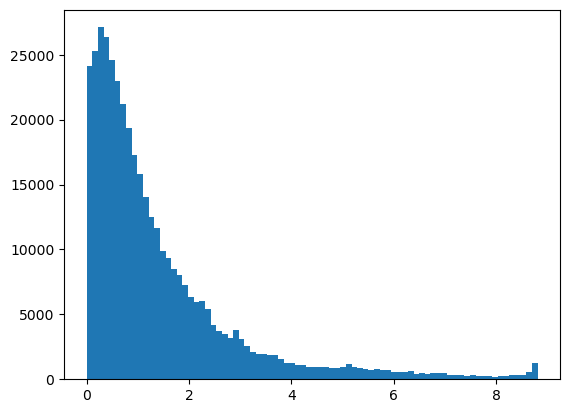

In [108]:
plt.hist(act_gauss.numpy().ravel(), bins=80)
plt.show()

But we can't even see the negative numbers... Let's count the numbers that are below 0:

In [109]:
(act_gauss.numpy()<0).sum()

102

Curiously enough, there are the same amount of negative numbers that of `nan`... Interesting enough. Let's try to add a clip to the output of the gaussian layer to see if it fixes our `nan` problems:

In [114]:
class GDNConv(layers.Layer):
    """GDN that takes as input a specific layer to use."""

    def __init__(self,
                 layer, # Layer to be used to extract the normalization.
                 **kwargs,
                 ):
        super(GDNConv, self).__init__(**kwargs)
        self.layer = layer

    def build(self,
              input_shape,
              ):
        self.layer.build(input_shape)
        self.alpha = tf.Variable(2, trainable=False, name="alpha", dtype=tf.float32)
        self.epsilon = tf.Variable(1/2, trainable=False, name="epsilon", dtype=tf.float32)
        # self.beta = tf.Variable(1, trainable=True, name="beta", dtype=tf.float32)

    def call(self,
             X,
             training=False,
             ):
        norm = tf.math.pow(X, self.alpha)
        norm = self.layer(norm, training=training)#+self.beta
        norm = tf.clip_by_value(norm, clip_value_min=0, clip_value_max=tf.reduce_max(norm))
        norm = tf.math.pow(norm, self.epsilon)
        return X / norm

In [115]:
model = tf.keras.Sequential([
    GDNConv(SimpleGaussian(filters=3, kernel_size=11), input_shape=X_train[0].shape),
    layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
    layers.MaxPool2D(2),
    layers.GlobalAveragePooling2D(),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
# model.summary()

In [116]:
history = model.fit(X_train, Y_train, epochs=1, batch_size=128, validation_split=0.2)

313/313 [==============================] - 9s 21ms/step - loss: 2.3026 - accuracy: 0.0966 - val_loss: 2.3027 - val_accuracy: 0.0952


In [117]:
model.layers[0].variables

[<tf.Variable 'gdn_conv_8/simple_gaussian_10/x0:0' shape=(3,) dtype=float32, numpy=array([nan, nan, nan], dtype=float32)>,
 <tf.Variable 'gdn_conv_8/simple_gaussian_10/y0:0' shape=(3,) dtype=float32, numpy=array([nan, nan, nan], dtype=float32)>,
 <tf.Variable 'gdn_conv_8/simple_gaussian_10/logsigma_x:0' shape=(3,) dtype=float32, numpy=array([nan, nan, nan], dtype=float32)>,
 <tf.Variable 'gdn_conv_8/simple_gaussian_10/logsigma_y:0' shape=(3,) dtype=float32, numpy=array([nan, nan, nan], dtype=float32)>,
 <tf.Variable 'gdn_conv_8/alpha:0' shape=() dtype=float32, numpy=2.0>,
 <tf.Variable 'gdn_conv_8/epsilon:0' shape=() dtype=float32, numpy=0.5>]

Still didn't fix it... Let's inspect the activations again...

In [118]:
model = tf.keras.Sequential([
    GDNConv(SimpleGaussian(filters=3, kernel_size=11), input_shape=X_train[0].shape),
    layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
    layers.MaxPool2D(2),
    layers.GlobalAveragePooling2D(),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
# model.summary()

In [130]:
EPOCHS = 5
BATCH_SIZE = 128


for epoch in range(EPOCHS):
    for X, Y in dst_train.batch(BATCH_SIZE):
        input_gauss = tf.math.pow(X, model.layers[0].alpha)
        act_gauss = model.layers[0].layer(input_gauss)
        act_gauss_clip = tf.clip_by_value(act_gauss, clip_value_min=0, clip_value_max=tf.reduce_max(act_gauss))
        act_gauss_eps = tf.math.pow(act_gauss_clip, model.layers[0].epsilon)
        break
    break

In [131]:
tf.reduce_min(act_gauss), tf.reduce_max(act_gauss)

(<tf.Tensor: shape=(), dtype=float32, numpy=-6.968912e-08>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.6339989>)

In [132]:
tf.reduce_min(act_gauss_clip), tf.reduce_max(act_gauss_clip)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.6339989>)

In [133]:
tf.reduce_min(act_gauss_eps), tf.reduce_max(act_gauss_eps)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.62296>)

At least we are not getting `nan` after the power to `epsilon` anymore... Now the problem must be elsewhere... We will look into the division now, it's the only part of the layer we have left. We can predict that there are going to be `nan` because of the division by 0, but we can get around that if we clip our values to a sligtly higher number insted:

In [135]:
EPOCHS = 5
BATCH_SIZE = 128


for epoch in range(EPOCHS):
    for X, Y in dst_train.batch(BATCH_SIZE):
        input_gauss = tf.math.pow(X, model.layers[0].alpha)
        act_gauss = model.layers[0].layer(input_gauss)
        act_gauss_clip = tf.clip_by_value(act_gauss, clip_value_min=1e-5, clip_value_max=tf.reduce_max(act_gauss))
        act_gauss_eps = tf.math.pow(act_gauss_clip, model.layers[0].epsilon)
        X_norm = X / act_gauss_eps
        break
    break

In [136]:
tf.reduce_min(act_gauss), tf.reduce_max(act_gauss)

(<tf.Tensor: shape=(), dtype=float32, numpy=-6.968912e-08>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.6339989>)

In [137]:
tf.reduce_min(act_gauss_clip), tf.reduce_max(act_gauss_clip)

(<tf.Tensor: shape=(), dtype=float32, numpy=1e-05>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.6339989>)

In [138]:
tf.reduce_min(act_gauss_eps), tf.reduce_max(act_gauss_eps)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.0031622776>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.62296>)

In [139]:
tf.reduce_min(X_norm), tf.reduce_max(X_norm)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.5626142>)

Let's see...

In [140]:
#| export
class GDNConv(layers.Layer):
    """GDN that takes as input a specific layer to use."""

    def __init__(self,
                 layer, # Layer to be used to extract the normalization.
                 **kwargs,
                 ):
        super(GDNConv, self).__init__(**kwargs)
        self.layer = layer

    def build(self,
              input_shape,
              ):
        self.layer.build(input_shape)
        self.alpha = tf.Variable(2, trainable=False, name="alpha", dtype=tf.float32)
        self.epsilon = tf.Variable(1/2, trainable=False, name="epsilon", dtype=tf.float32)
        # self.beta = tf.Variable(1, trainable=True, name="beta", dtype=tf.float32)

    def call(self,
             X,
             training=False,
             ):
        norm = tf.math.pow(X, self.alpha)
        norm = self.layer(norm, training=training)#+self.beta
        norm = tf.clip_by_value(norm, clip_value_min=1e-5, clip_value_max=tf.reduce_max(norm))
        norm = tf.math.pow(norm, self.epsilon)
        return X / norm

In [141]:
model = tf.keras.Sequential([
    GDNConv(SimpleGaussian(filters=3, kernel_size=11), input_shape=X_train[0].shape),
    layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
    layers.MaxPool2D(2),
    layers.GlobalAveragePooling2D(),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
# model.summary()

In [142]:
history = model.fit(X_train, Y_train, epochs=1, batch_size=128, validation_split=0.2)

313/313 [==============================] - 9s 21ms/step - loss: 2.2276 - accuracy: 0.1646 - val_loss: 2.1436 - val_accuracy: 0.1906


In [143]:
model.layers[0].variables

[<tf.Variable 'gdn_conv_10/simple_gaussian_12/x0:0' shape=(3,) dtype=float32, numpy=array([5.021589 , 5.0748296, 5.033156 ], dtype=float32)>,
 <tf.Variable 'gdn_conv_10/simple_gaussian_12/y0:0' shape=(3,) dtype=float32, numpy=array([4.541341 , 5.0774646, 5.2000704], dtype=float32)>,
 <tf.Variable 'gdn_conv_10/simple_gaussian_12/logsigma_x:0' shape=(3,) dtype=float32, numpy=array([ 1.5395051, -1.5839721,  0.3694521], dtype=float32)>,
 <tf.Variable 'gdn_conv_10/simple_gaussian_12/logsigma_y:0' shape=(3,) dtype=float32, numpy=array([ 0.5664232, -1.3419263, -1.7814674], dtype=float32)>,
 <tf.Variable 'gdn_conv_10/alpha:0' shape=() dtype=float32, numpy=2.0>,
 <tf.Variable 'gdn_conv_10/epsilon:0' shape=() dtype=float32, numpy=0.5>]

**IT'S TRAINIG NOW**

![HURRAY](https://www.memecreator.org/static/images/memes/5145525.jpg "HURRAY")

## Simple Gaussian as inheriting from `Conv2D`

In [ ]:
class SimpleGaussian2D(layers.Conv2D):
    """Simple Gaussian implementation inheriting from Keras' Conv2D."""

    def build(self,
              input_shape,
              ):
        super(SimpleGaussian2D, self).build(input_shape)
        self.x0 = tf.Variable([self.kernel_size[0]//2]*self.filters, trainable=True, dtype=tf.float32)
        self.y0 = tf.Variable([self.kernel_size[1]//2]*self.filters, trainable=True, dtype=tf.float32)
        self.logsigma_x = tf.Variable(np.random.uniform(low=-2, high=2, size=self.filters), trainable=True, dtype=tf.float32)
        self.logsigma_y = tf.Variable(np.random.uniform(low=-2, high=2, size=self.filters), trainable=True, dtype=tf.float32)
        self.A = tf.Variable(1, trainable=False, name="A", dtype=tf.float32)

    @property
    def sigma_x(self):
        return tf.math.exp(self.logsigma_x)

    @property
    def sigma_y(self):
        return tf.math.exp(self.logsigma_y)

    def call(self,
             X,
             training=False,
             ):
        
        ## 1. Build the filters (n_filters, kernel_size, kernel_size)
        filters = self.build_filters()

        ## 2. Reshape so they match what Keras expects (Kx, Ky, Cin, Cout)
        filters = repeat(filters, "n_filters kx ky -> kx ky Cin n_filters", Cin=X.shape[-1])

        # return tf.nn.conv2d(X, filters, strides=self.strides, padding=self.padding)
        return self.convolution_op(X, filters)
    
    # @property
    # def kernel(self):
    #     ## 1. Build the filters (n_filters, kernel_size, kernel_size)
    #     filters = self.build_filters()

    #     ## 2. Reshape so they match what Keras expects (Kx, Ky, Cin, Cout)
    #     filters = repeat(filters, "n_filters kx ky -> kx ky Cin n_filters", Cin=X.shape[-1])

    #     return filters

    @tf.function
    def _build_filter(self,
                      x, # X domain.
                      y, # Y domain.
                      x0, # Mean of X.
                      y0, # Mean of Y.
                      sigma_x, # Width of X.
                      sigma_y, # Width of Y.
                      A, # Height of the peak.
                      ):
        """Builds the gaussian filters using the parameters of the layer."""

        ## 2. Build the gaussian
        return A*tf.math.exp(-((x-x0)**2/(2*sigma_x**2)+(y-y0)**2/(2*sigma_y**2)))

    @tf.function
    def build_filters(self):
        ## 1. Build domain
        x, y = tf.meshgrid(tf.range(self.kernel_size[0]), tf.range(self.kernel_size[1]))
        x, y = tf.cast(x, dtype=tf.float32), tf.cast(y, dtype=tf.float32)
        
        ## 2. Initialize empty `TensorArray`
        filters = tf.TensorArray(dtype = tf.float32, size = self.filters)

        for n in tf.range(start=0, limit=self.filters, dtype=tf.int32):
            filters = filters.write(n, 
                                    self._build_filter(x, y, 
                                                       tf.gather(self.x0, n), tf.gather(self.y0, n), 
                                                       tf.gather(self.sigma_x, n), tf.gather(self.sigma_y, n),
                                                       self.A))

        filters = filters.stack()
        ## Normalize the filters
        # if normalize: 
        #     max_per_filter = reduce(gaussians, "filters Ncols Nrows -> filters () ()", "max")
        #     gaussians = gaussians/(max_per_filter*tf.cast(filters, tf.float32))
        return filters

    def show_filters(self,
                     show=True, # Wether to do plt.show() or not.
                     ):
        """Plots the filters created with the current parameters."""
        ncols = int(np.sqrt(self.filters))
        nrows = int(self.filters-ncols)
        if nrows == 0: nrows == 1
        filters = self.build_filters().numpy()
        fig, axes = plt.subplots(ncols, nrows)
        for filter, ax in zip(filters, axes.ravel()):
            ax.imshow(filter)
            ax.axis("off")
        if show: plt.show()

In [124]:
sg2d = SimpleGaussian2D(filters=4, kernel_size=11)
sg2d.build((None, 28, 28, 1))

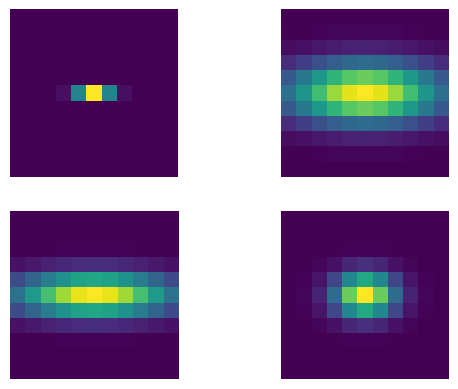

In [125]:
sg2d.show_filters()

In [126]:
model = tf.keras.Sequential([
    SimpleGaussian2D(filters=3, kernel_size=11, input_shape=X_train[0].shape),
    layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
    layers.MaxPool2D(2),
    layers.GlobalAveragePooling2D(),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

AttributeError: in user code:

    /tmp/ipykernel_29294/341854560.py:34 call  *
        return self.convolution_op(X, filters)

    AttributeError: 'SimpleGaussian2D' object has no attribute 'convolution_op'


In [ ]:
history = model.fit(X_train, Y_train, epochs=5, batch_size=128, validation_split=0.2)

Epoch 1/5
313/313 [==============================] - 8s 20ms/step - loss: 2.3027 - accuracy: 0.0997 - val_loss: 2.3027 - val_accuracy: 0.0952
Epoch 2/5
313/313 [==============================] - 5s 16ms/step - loss: 2.3027 - accuracy: 0.1003 - val_loss: 2.3027 - val_accuracy: 0.0952
Epoch 3/5
313/313 [==============================] - 5s 16ms/step - loss: 2.3027 - accuracy: 0.0998 - val_loss: 2.3028 - val_accuracy: 0.0952
Epoch 4/5
313/313 [==============================] - 5s 16ms/step - loss: 2.3027 - accuracy: 0.1012 - val_loss: 2.3027 - val_accuracy: 0.0980
Epoch 5/5
313/313 [==============================] - 5s 16ms/step - loss: 2.3027 - accuracy: 0.0982 - val_loss: 2.3027 - val_accuracy: 0.0952


In [ ]:
model.layers[0].layer.trainable_variables

[<tf.Variable 'gdn_conv_3/simple_gaussian_14/Variable:0' shape=(3,) dtype=float32, numpy=array([nan, nan, nan], dtype=float32)>,
 <tf.Variable 'gdn_conv_3/simple_gaussian_14/Variable:0' shape=(3,) dtype=float32, numpy=array([nan, nan, nan], dtype=float32)>,
 <tf.Variable 'gdn_conv_3/simple_gaussian_14/Variable:0' shape=(3,) dtype=float32, numpy=array([nan, nan, nan], dtype=float32)>,
 <tf.Variable 'gdn_conv_3/simple_gaussian_14/Variable:0' shape=(3,) dtype=float32, numpy=array([nan, nan, nan], dtype=float32)>]